* https://www.desmos.com/calculator/7wbvkts2jf
* https://atiselsts.github.io/pdfs/uniswap-v3-liquidity-math.pdf
* https://pandichef.medium.com/a-brief-history-of-uniswap-and-its-math-90443241c9b7

In [8]:
import scipy.special as sps 
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [9]:
def func_log(x, a, b, c):
    """Return values from a general log function."""
    return a * np.log(b * x) + c

def generate_data(func, *args, jitter=0, xs):
    """Return a tuple of arrays with random data along a general function."""
    ys = func(xs, *args)
    noise = jitter * np.random.normal(size=len(xs)) + jitter
    xs = xs.reshape(-1, 1)                                  # xs[:, np.newaxis]
    ys = (ys + noise).reshape(-1, 1)
    return xs, ys

def gen_liquidity(N, L):
    
    empty_dataset = np.zeros(N)
    mod = sm.tsa.SARIMAX(empty_dataset, order=(0, 1, 0), initialization='diffuse')
    simulations = mod.simulate([4**2], N)
    t = np.array(range(1,N+1))

    shape, scale = L, 3  
    s = np.random.gamma(shape, scale, N)

    x_samp, y_samp = generate_data(func_log, 1, 1.2, 0.7, xs=t)

    sim = (s+np.abs(simulations))*np.exp(y_samp.flatten())
    sim_liquidity = np.abs(simulations)/max(np.abs(simulations))
    
    return L*sim_liquidity


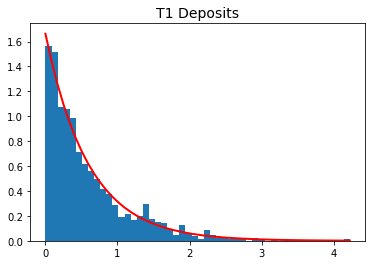

In [77]:
max_trade = 3
shape, scale = 1, max_trade/5  
s = np.random.gamma(shape, scale, 1000)

count, bins, ignored = plt.hist(s, 50, density=True)
y = bins**(shape-1)*(np.exp(-bins/scale) /  
                     (sps.gamma(shape)*scale**shape))
plt.plot(bins, y, linewidth=2, color='r')  
plt.title("T1 Deposits", fontsize=14)
plt.show()

In [11]:
def f(x, L):
    return L**2/x;

def x_p(L,p):
    return L/(p ** 0.5)

def y_p(L,p):
    return L*(p ** 0.5)

def pnt_p(L,p):
    return (x_p(L,p),y_p(L,p))

def x_in(pa,pb,L):
    return abs(x_p(L,pa) - x_p(L,pb))

def y_in(pa,pb,L):
    return abs(y_p(L,pa) - y_p(L,pb))

def exe_price(delta_x,delta_y):
    return delta_y/delta_x

def trade(x_swap,price):
    return price*x_swap

def random_trade(max_trade = 1):
    shape, scale = 1, max_trade/5
    trade = np.random.gamma(shape, scale, 1)
    return min(trade[0],max_trade)

def price_trade_x(p, del_x, L):
    a = p
    b = -p*del_x
    c = -L**2 
    return (-b + (b**2 - 4*a*c)**0.5)/(2*a)

In [21]:
p = 4
L = 5
price_factor = 2
pa = p/price_factor
pb = p*price_factor
bound = price_factor*L
d = 0.1

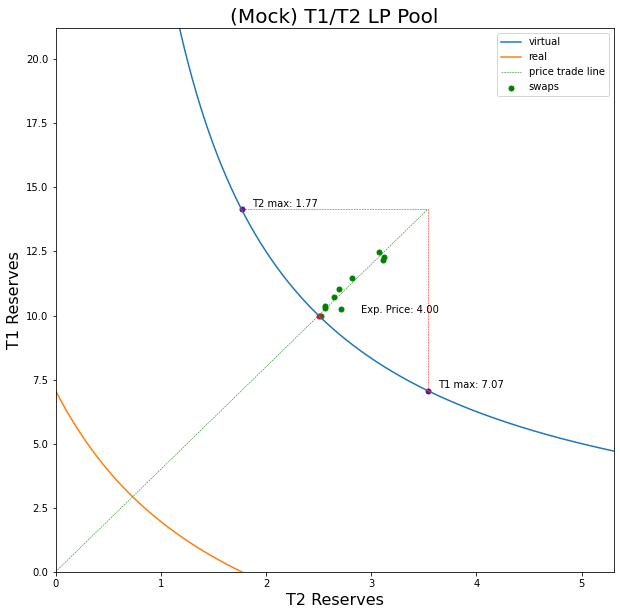

In [79]:
x_shift = 0.001
x_real = np.arange(x_shift, bound, 0.001)
x_virt = np.arange(x_shift, bound, 0.001)

y_virt = L**2/x_virt
y_real = L**2/(x_real+L/np.sqrt(pb)) - L*np.sqrt(pa)

fig, ax = plt.subplots(figsize=(10, 10))

plt.plot(x_virt, y_virt, label='virtual') 
plt.plot(x_real, y_real, label='real')

x_max = x_in(pa,pb,L); y_max = y_in(pa,pb,L)
x_pa = x_p(L,pa); y_pa = y_p(L,pa)
x_pb = x_p(L,pb); y_pb = y_p(L,pb)

plt.plot([x_pb,x_pa],[y_pb,y_pb],'r--',lw=0.5)
plt.plot([x_pa,x_pa],[y_pb,y_pa],'r--',lw=0.5)
plt.plot([0,x_pa],[0,y_pb],'g--',lw=0.5, label='price trade line')

x_swap = []; y_swap = []
for k in range(10):
    delta_x_swap = random_trade(x_max)
    x = price_trade_x(p, delta_x_swap, L)
    x_swap.append(x)
    y_swap.append(np.random.normal(p*x, 0.25, 1)[0])
    
plt.scatter([x_swap], [y_swap], marker='o', color='green',s=25, label = 'swaps')
plt.scatter([x_p(L,p)], [y_p(L,p)], marker='o', color='red',s=25)
plt.scatter([x_pb,x_pa], [y_pb,y_pa], marker='o', color='purple',s=25)
plt.text(x_pb+d, y_pb+d, 'T2 max: {:.2f}'.format(x_max))
plt.text(x_pa+d, y_pa+d, 'T1 max: {:.2f}'.format(y_max))

plt.text(x_p(L,p)+4*d, y_p(L,p)+d, 'Exp. Price: {:.2f}'.format(p))

plt.ylim(0, 1.5*y_pb)
plt.xlim(0, 1.5*x_pa)
plt.title("(Mock) T1/T2 LP Pool", fontsize=20)
plt.ylabel("T1 Reserves", fontsize=16)
plt.xlabel('T2 Reserves', fontsize=16)
plt.legend()


In [80]:
N = 100
sims = gen_liquidity(N,L).reshape(-1,1)
for k in range(1,50):
    liquidity = gen_liquidity(N,L).reshape(-1,1)
    sims = np.hstack((sims,liquidity))
    
liquidities = np.array([np.median(sims[k,:]) for k in range(len(sims))])
prices = np.random.normal(p, 0.25, N)

In [81]:
L = liquidities[1]
x_max = x_in(pa,pb,L); y_max = y_in(pa,pb,L)
reserves = np.array([x_max, y_max])

for k in range(2,len(liquidities)):
    L = liquidities[k]
    pa = p/price_factor
    pb = p*price_factor
    x_max = x_in(pa,pb,L); y_max = y_in(pa,pb,L)
    reserves = np.vstack((reserves, np.array([x_max, y_max]))) 

Text(0.5, 0, 'Time unit')

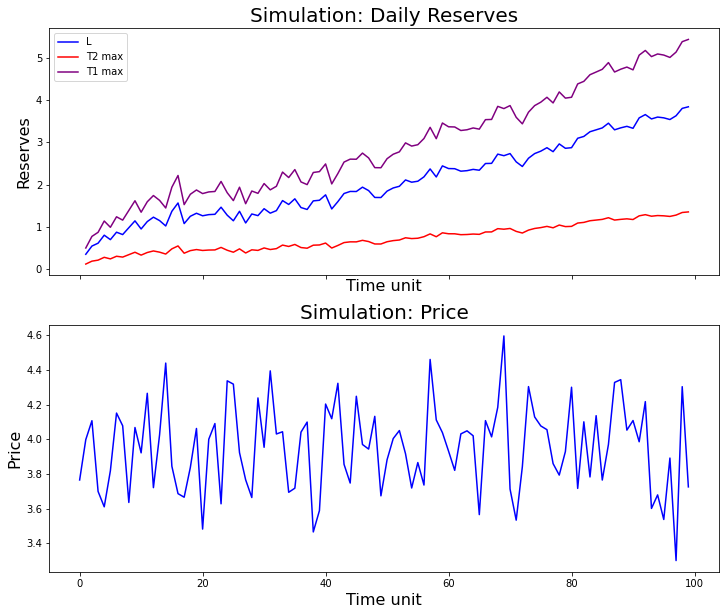

In [92]:
reserves_x = reserves[:,0]
reserves_y = reserves[:,1]
t = np.array(range(N))

fig, (reserves_ax, price_ax) = plt.subplots(nrows=2, sharex=True, sharey=False, figsize=(12, 10))
reserves_ax.plot(t[1:], liquidities[1:], color='blue',label='L');
reserves_ax.plot(t[1:], reserves_x, color='red',label='T2 max');
reserves_ax.plot(t[1:], reserves_y, color='purple',label='T1 max');
reserves_ax.set_title("Simulation: Daily Reserves", fontsize=20)
reserves_ax.set_ylabel("Reserves", fontsize=16)
reserves_ax.set_xlabel('Time unit', fontsize=16)
reserves_ax.legend()

price_ax.plot(t, prices, color='blue',label='L');
price_ax.set_title("Simulation: Price", fontsize=20)
price_ax.set_ylabel("Price", fontsize=16)
price_ax.set_xlabel('Time unit', fontsize=16)


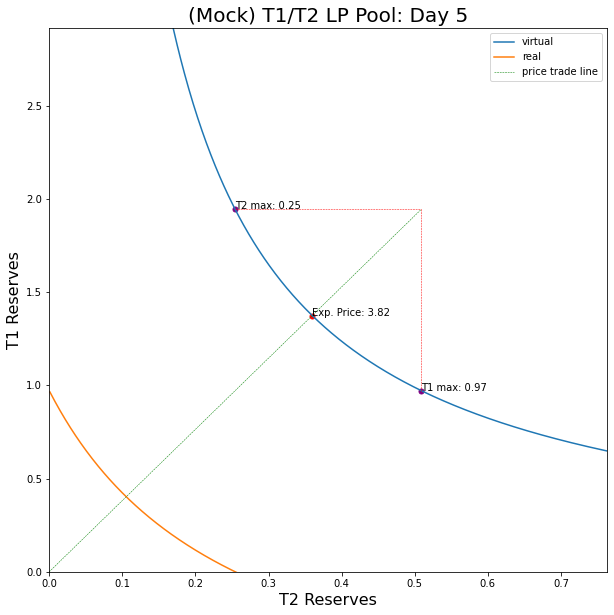

In [86]:
DAY = 5

L = liquidities[DAY]
price = prices[DAY]
pa = price/price_factor
pb = price*price_factor

x_shift = 0.001
x_real = np.arange(x_shift, bound, 0.001)
x_virt = np.arange(x_shift, bound, 0.001)

y_virt = L**2/x_virt
y_real = L**2/(x_real+L/np.sqrt(pb)) - L*np.sqrt(pa)

fig, ax = plt.subplots(figsize=(10, 10))

plt.plot(x_virt, y_virt, label='virtual') 
plt.plot(x_real, y_real, label='real')

x_max = x_in(pa,pb,L); y_max = y_in(pa,pb,L)
x_pa = x_p(L,pa); y_pa = y_p(L,pa)
x_pb = x_p(L,pb); y_pb = y_p(L,pb)

plt.plot([x_pb,x_pa],[y_pb,y_pb],'r--',lw=0.5)
plt.plot([x_pa,x_pa],[y_pb,y_pa],'r--',lw=0.5)
plt.plot([0,x_pa],[0,y_pb],'g--',lw=0.5, label='price trade line')
    
plt.scatter([x_p(L,price)], [y_p(L,price)], marker='o', color='red',s=25)
plt.scatter([x_pb,x_pa], [y_pb,y_pa], marker='o', color='purple',s=25)
plt.text(x_pb, y_pb, 'T2 max: {:.2f}'.format(x_max))
plt.text(x_pa, y_pa, 'T1 max: {:.2f}'.format(y_max))

plt.text(x_p(L,price), y_p(L,price), 'Exp. Price: {:.2f}'.format(price))

plt.ylim(0, 1.5*y_pb)
plt.xlim(0, 1.5*x_pa)
plt.title("(Mock) T1/T2 LP Pool: Day {}".format(DAY), fontsize=20)
plt.ylabel("T1 Reserves", fontsize=16)
plt.xlabel('T2 Reserves', fontsize=16)
plt.legend()